# Question 2: Multiple hypothesis testing / decision making

## Research Question

**What is your second research question?** 

For each state (NY and CA) by county, is there a significant association between temporal mobility and COVID-19 cases in 2020?

**What real-world decision(s) could be made by answering it?**

Our research question explores the impact of a pandemic on different kinds of mobility 2 in densely populated states in the US. Such analysis could be helpful in informing resource allocation for maximum efficiency, political policy, and even targetted marketing campaigns for businesses as we continue to battle new variants of the virus and in future if we are faced with similar problems.

**Explain why the method you will use is a good fit for the question (for example, if you
choose causal inference, you should explain why causal inference is a good fit for answering
your research question).**

We chose to examine this research question through multiple hypothesis testing, which is generally useful when we have more than one null hypothesis that we would like to test using a single kind of test. In this particular situation, the hypotheses we wanted to look into involved how different kinds of mobility (e.g. residential and workplace) were impacted by the pandemic, if at all.

## EDA

**Visualize at least two quantitative variables and two categorical variables. Your visualizations
must be relevant to your research questions!**

1) *Quantitative:* Proportion change in each type of mobility from baseline (cubed) against proportion of positive COVID-19 tests for each state.

2) *Quantitative:* Proportion of positive COVID-19 tests against test statistic measuring impact of COVID-19 cases on each type of mobility for each state.


**Describe any trends you observe, and any relationships you may want to follow up on.**

1) There is a consistent trend in values in change in mobility cubed clustering around 0 when the proportion of positive cases were around 0. This implies that a relationship between the two variables exists whereby mobility does not change much when there are a low proportion of positive COVID-19 tests.

2) The graphs indicate that a higher proportion of test cases has led to lower retail and recreational, transit station and workspace mobility, higher park and residential mobility, and roughly no change in grocery and pharmacy mobility. This is in-line with our own assumptions that the pandemic led to more people staying home or going to outdoor spaces and less people going to work (WFH) and going to public places like transit stations or doing in-door recreational activities. Essential activities like grocery shopping and going to the pharmacy remain less impacted.


**Describe any data cleaning steps you took. How will these decisions impact your model and
inferences?**

1) Preliminary steps: Renaming columns for consistency across datasets and readability, selecting only useful columns, and merging the datasets to consolidate the data in one table for each state.

2) Converting date columns to datetime objects from strings so we could filter the data to only contain information for the year 2020.

3) Creating a new column called 'prop_positive' to reflect the proportion of positive tests as opposed to the number of positive tests as counties with higher populations as well as higher rates of testing would have more positive cases than those with lower populations/testing rates. This would confound our analysis of the impact of positive tests on different kinds of mobility.

4) Converting the percentage change in different types of mobility from baseline values to proportions for consistency and to keep the values under 1, which makes them easier to graph when we cube them later on.

5) Dropping the rows that were null because of 0 total COVID tests because the number is insignificant and if there were 0 tests conducted, we can't say anything about the impact of positive cases on mobility.

6) Removing the 15 (CA) and 5 (NY) rows where all the people tested were positive as the formula we created later on has a 1 - prop_positive in the denominator and a prop_positive = 1 would mean that the impact of positive cases on mobility is infinity, which is incorrect.

7) Creating a test statistic to determine the impact of the proportion of positive test cases on each kind of mobility. The test statistic increases with a higher proportion of change in mobility from baseline as well as with an increase in the proportion of positive cases. This is so that we can accurately measure the impact of the latter on the former. For instance, a significant impact of COVID cases on mobility would be reflected in a high absolute value of the test statistic even when the change in mobility is low if the proportion of positive cases is high and vice versa.

**Explain how your visualizations are relevant to your research questions: do they motivate the
question you’re asking? Do they suggest a potential answer?
– For example, are there particular groups that have higher frequencies of missing values?**

1) This visualization was useful in our EDA to see whether or not a trend even existed between the two quantitative variables.

2) This visualization was useful in checking that our test statistic was working correctly-- showing that the impacts of a high proportion of positive test cases was what we intuitively believed it would be.

**Explain how your visualizations should be relevant to your research questions: either by moti-
vating the question, or suggesting a potential answer. You must explain why they are relevant.**

1) The visualization suggested that there was indeed a relationship as very low values in the proportion of positive COVID-19 cases were clustered around very low changes in mobility.

2) They suggested that there was indeed an impact of test cases on mobility. In some cases, mobility increased with more cases and in some cases it decreased. It allowed us to create a model on the basis of this test statistic.

### Data Cleaning

In [1]:
# Remove warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
import time
from datetime import datetime

In [3]:
# Reading mobility data

mobility = pd.read_csv('2020_US_Region_Mobility_Report.csv')

# Renaming columns to be more readable

mobility = mobility.rename(columns = {'sub_region_2': 'County'})

# Converting date field to datetime object

mobility['date'] = pd.to_datetime(mobility['date'])

# Dropping irrelevant columns

mobility = mobility.drop(['iso_3166_2_code', 'country_region_code', 'country_region', 'metro_area', 'place_id',
                                'census_fips_code'], axis = 1)

# Separating CA data and removing null rows

ca_mobility = mobility[mobility.sub_region_1 == "California"].dropna()
ca_mobility['County'] = ca_mobility['County'].str.replace(' County', '')

# Separating NY data and removing null rows

ny_mobility = mobility[mobility.sub_region_1 == "New York"].dropna()
ny_mobility['County'] = ny_mobility['County'].str.replace(' County', '')

In [4]:
# Reading data for confirmed cases, deaths and recoveries for COVID-19 in CA

ca_cases = pd.read_csv("ca_cases.csv")

# Selecting relevant columns

ca_cases = ca_cases[['date', 'area', 'positive_tests', 'cumulative_positive_tests', 'total_tests', 
                    'cumulative_total_tests']]

# Converting date to datetime object

ca_cases['date'] = pd.to_datetime(ca_cases['date'])

# Renaming for consistency and dropping null rows

ca_cases = ca_cases.rename(columns = {'area': 'County'}).dropna()

# Selecting only data from 2020

ca_cases = ca_cases[ca_cases['date'] < datetime(year=2021, month=1, day=1)]
ca_cases.head()

,date,County,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,2020-02-01,Alameda,0.0,0,4.0,4
1,2020-02-01,Stanislaus,0.0,0,1.0,1
2,2020-02-01,Alpine,0.0,0,0.0,0
3,2020-02-01,Sonoma,0.0,0,0.0,0
4,2020-02-01,Amador,0.0,0,0.0,0


In [5]:
# Reading data for confirmed cases, deaths and recoveries for COVID-19 in NY

ny_cases = pd.read_csv("New_York_State_Statewide_COVID-19_Testing.csv")

# Eenaming for consistency and dropping null rows

ny_cases = ny_cases.rename(columns = {'Test Date': 'date', 'New Positives': 'positive_tests',
                                     'Cumulative Number of Positives': 'cumulative_positive_tests',
                                     'Total Number of Tests Performed': 'total_tests',
                                     'Cumulative Number of Tests Performed': 'cumulative_total_tests'}).dropna()

# Converting date to datetime object

ny_cases['date'] = pd.to_datetime(ny_cases['date'])

# Selecting only data from 2020

ny_cases = ny_cases[ny_cases['date'] < datetime(year=2021, month=1, day=1)]
ny_cases.head()

,date,County,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,2020-03-01,Albany,0,0,0,0
1,2020-03-02,Albany,0,0,0,0
2,2020-03-03,Albany,0,0,0,0
3,2020-03-04,Albany,0,0,0,0
4,2020-03-05,Albany,0,0,3,3


In [6]:
# Merging CA and NY data to one table (per state) on date and county

ca_data = pd.merge(ca_mobility, ca_cases,  how = 'inner', left_on = ['date','County'], right_on = ['date','County'])
ny_data = pd.merge(ny_mobility, ny_cases,  how = 'inner', left_on = ['date','County'], right_on = ['date','County'])

# Renaming for more readability

ca_data = ca_data.rename(columns = {'sub_region_1': 'state'})
ny_data = ny_data.rename(columns = {'sub_region_1': 'state'})

# Sorting values by date in ascending order

ca_data = ca_data.sort_values('date')
ny_data = ny_data.sort_values('date')

# Creating a new column to reflect the proportion of positive tests as opposed to the number of positive
# tests as counties with higher populations as well as higher rates of testing would have more 
# positive cases than those with lower populations/testing rates. This would confound our analysis
# of the impact of positive tests on different kinds of mobility

ca_data['prop_positive'] = ca_data['positive_tests']/ca_data['total_tests']
ny_data['prop_positive'] = ny_data['positive_tests']/ny_data['total_tests']

# Converting the percentage change in different types of mobility from baseline values to
# proportions for consistency and to keep the values under 1 (easier to graph)

ca_data['retail_and_recreation_prop_change_from_baseline'] = ca_data[
    'retail_and_recreation_percent_change_from_baseline']/100
ca_data['grocery_and_pharmacy_prop_change_from_baseline'] = ca_data[
    'grocery_and_pharmacy_percent_change_from_baseline']/100
ca_data['parks_prop_change_from_baseline'] = ca_data['parks_percent_change_from_baseline']/100
ca_data['transit_stations_prop_change_from_baseline'] = ca_data[
    'transit_stations_percent_change_from_baseline']/100
ca_data['workplaces_prop_change_from_baseline'] = ca_data['workplaces_percent_change_from_baseline']/100
ca_data['residential_prop_change_from_baseline'] = ca_data['residential_percent_change_from_baseline']/100

ny_data['retail_and_recreation_prop_change_from_baseline'] = ny_data[
    'retail_and_recreation_percent_change_from_baseline']/100
ny_data['grocery_and_pharmacy_prop_change_from_baseline'] = ny_data[
    'grocery_and_pharmacy_percent_change_from_baseline']/100
ny_data['parks_prop_change_from_baseline'] = ny_data['parks_percent_change_from_baseline']/100
ny_data['transit_stations_prop_change_from_baseline'] = ny_data[
    'transit_stations_percent_change_from_baseline']/100
ny_data['workplaces_prop_change_from_baseline'] = ny_data['workplaces_percent_change_from_baseline']/100
ny_data['residential_prop_change_from_baseline'] = ny_data['residential_percent_change_from_baseline']/100

# Drop the rows that were null because of 0 total COVID tests because the number is insignificant
# and if there were 0 tests conducted, we can't say anything about the impact of positive cases
# on mobility 

ca_data = ca_data.dropna()
ny_data = ny_data.dropna()

# Selecting only relevant columns

ca_data = ca_data[['state', 'County', 'date', 'prop_positive', 'retail_and_recreation_prop_change_from_baseline',
                  'grocery_and_pharmacy_prop_change_from_baseline', 'parks_prop_change_from_baseline',
                  'transit_stations_prop_change_from_baseline', 'workplaces_prop_change_from_baseline',
                  'residential_prop_change_from_baseline']]

ny_data = ny_data[['state', 'County', 'date', 'prop_positive', 'retail_and_recreation_prop_change_from_baseline',
                  'grocery_and_pharmacy_prop_change_from_baseline', 'parks_prop_change_from_baseline',
                  'transit_stations_prop_change_from_baseline', 'workplaces_prop_change_from_baseline',
                  'residential_prop_change_from_baseline']]

# removing the 15 (CA) and 5 (NY) rows where all the people tested were positive as the formula we created later on 
# has a 1 - prop_positive in the denominator and a prop_positive = 1 would mean that the impact
# of positive cases on mobility is infinity, which is incorrect

ca_data = ca_data[ca_data['prop_positive'] != 1]
ny_data = ny_data[ny_data['prop_positive'] != 1]

In [7]:
# Creating a test statistic to determine the impact of the proportion of positive test cases
# on each kind of mobility. The test statistic increases with a higher proportion of change in mobility
# from baseline as well as with an increase in the proportion of positive cases. This is so that
# we can accurately measure the impact of the latter on the former. For instance, a significant impact of 
# COVID cases on mobility would be reflected in a high absolute value of the test statistic even when the change in 
# mobility is low if the proportion of positive cases is high and vice versa

# CA data

ca_data['test_stat_retail_and_recreation'] = (ca_data['retail_and_recreation_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_grocery_and_pharmacy'] = (ca_data['grocery_and_pharmacy_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_parks'] = (ca_data['parks_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_transit_stations'] = (ca_data['transit_stations_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_workplaces'] = (ca_data['workplaces_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])
ca_data['test_stat_residential'] = (ca_data['residential_prop_change_from_baseline']) / abs(
    1 - ca_data['prop_positive'])

# NY data

ny_data['test_stat_retail_and_recreation'] = (ny_data['retail_and_recreation_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_grocery_and_pharmacy'] = (ny_data['grocery_and_pharmacy_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_parks'] = (ny_data['parks_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_transit_stations'] = (ny_data['transit_stations_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_workplaces'] = (ny_data['workplaces_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])
ny_data['test_stat_residential'] = (ny_data['residential_prop_change_from_baseline']) / abs(
    1 - ny_data['prop_positive'])

In [8]:
ca_data.head()

,state,County,date,prop_positive,retail_and_recreation_prop_change_from_baseline,grocery_and_pharmacy_prop_change_from_baseline,parks_prop_change_from_baseline,transit_stations_prop_change_from_baseline,workplaces_prop_change_from_baseline,residential_prop_change_from_baseline,test_stat_retail_and_recreation,test_stat_grocery_and_pharmacy,test_stat_parks,test_stat_transit_stations,test_stat_workplaces,test_stat_residential
10545,California,Ventura,2020-02-15,0.0,0.01,-0.02,0.07,-0.01,-0.01,0.00,0.01,-0.02,0.07,-0.01,-0.01,0.00
10249,California,Tulare,2020-02-15,0.0,0.01,0.01,0.22,0.15,-0.03,0.00,0.01,0.01,0.22,0.15,-0.03,0.00
2190,California,Kings,2020-02-15,0.0,0.07,-0.01,0.14,0.16,-0.03,-0.01,0.07,-0.01,0.14,0.16,-0.03,-0.01
2663,California,Los Angeles,2020-02-15,0.0,0.01,0.00,0.13,-0.01,-0.01,0.00,0.01,0.00,0.13,-0.01,-0.01,0.00
7351,California,San Luis Obispo,2020-02-15,0.0,0.16,0.09,0.43,0.09,0.00,-0.01,0.16,0.09,0.43,0.09,0.00,-0.01


In [9]:
ny_data.head()

,state,County,date,prop_positive,retail_and_recreation_prop_change_from_baseline,grocery_and_pharmacy_prop_change_from_baseline,parks_prop_change_from_baseline,transit_stations_prop_change_from_baseline,workplaces_prop_change_from_baseline,residential_prop_change_from_baseline,test_stat_retail_and_recreation,test_stat_grocery_and_pharmacy,test_stat_parks,test_stat_transit_stations,test_stat_workplaces,test_stat_residential
5378,New York,Westchester,2020-03-03,0.0,0.05,0.03,0.08,-0.01,0.03,0.0,0.05,0.03,0.08,-0.01,0.03,0.0
249,New York,Bronx,2020-03-03,0.0,0.08,0.07,0.06,0.04,0.04,0.0,0.08,0.07,0.06,0.04,0.04,0.0
3431,New York,Queens,2020-03-03,0.0,0.02,0.04,0.09,-0.03,0.04,0.0,0.02,0.04,0.09,-0.03,0.04,0.0
1262,New York,Kings,2020-03-03,0.0,0.04,0.06,0.06,0.02,0.04,0.0,0.04,0.06,0.06,0.02,0.04,0.0
2088,New York,New York,2020-03-03,0.0,0.00,0.06,0.05,-0.01,0.03,0.0,0.00,0.06,0.05,-0.01,0.03,0.0


### Visualizations

### #1

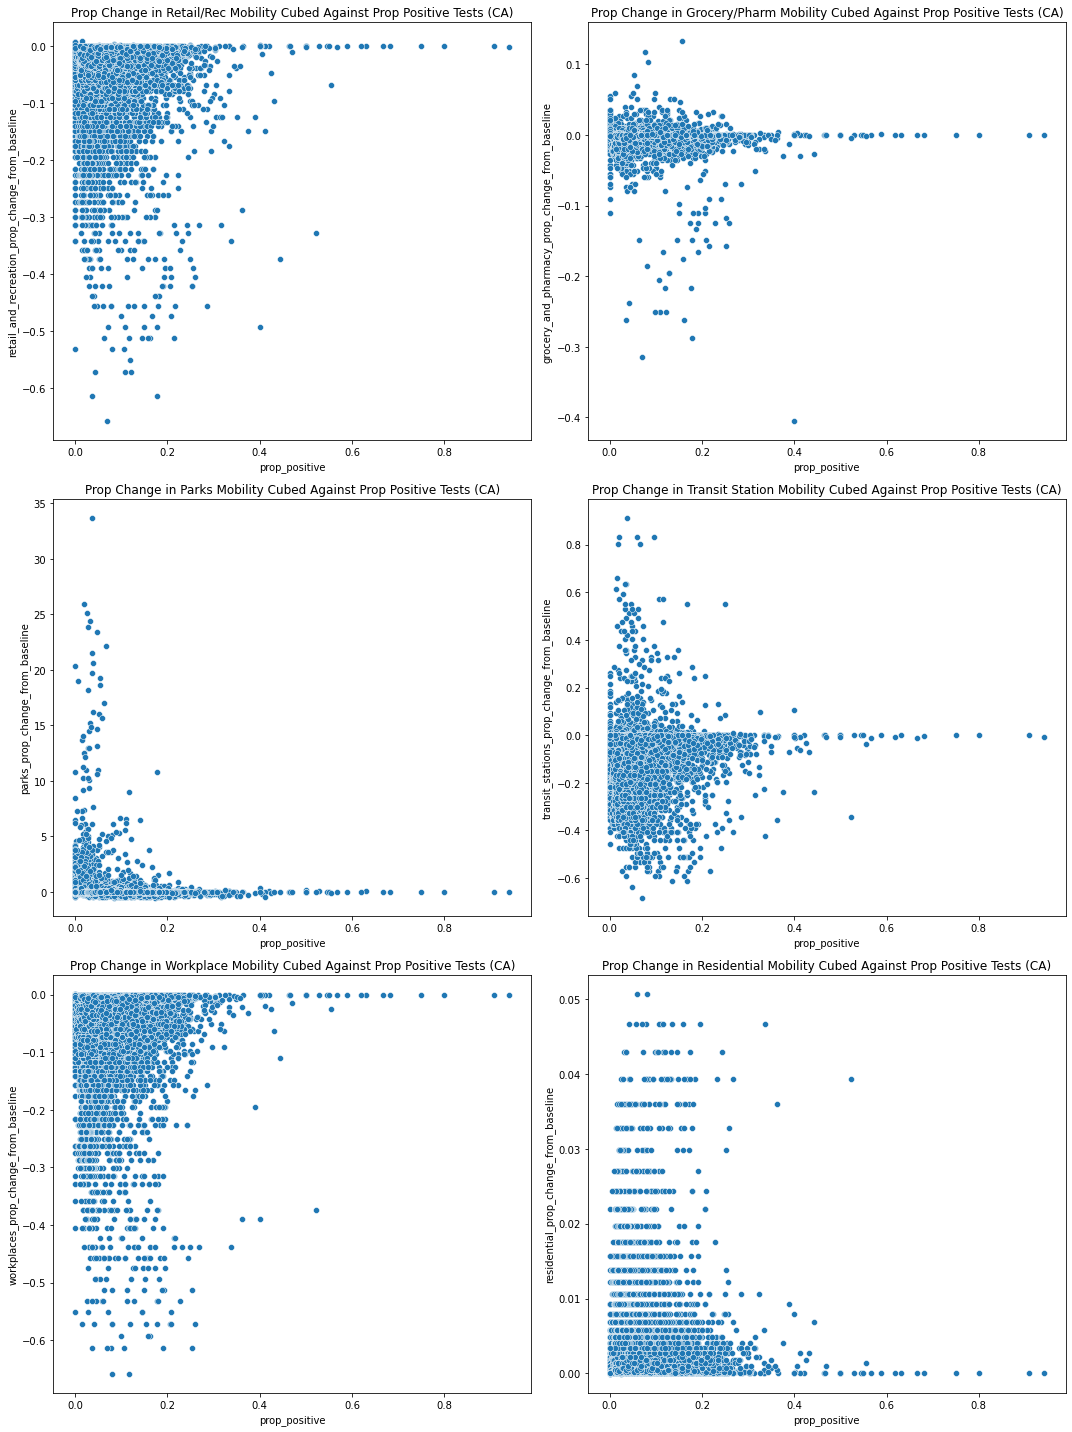

In [10]:
# Plotting the impact of the proportion of positive COVID-19 tests on the proportion change in mobility
# from baseline for each kind of mobility. As we can see from the graphs, there is a consistent trend in values
# in change in mobility clustering around 0 when the proportion of positive cases were around 0. We cubed
# the mobility proportion to compress our y-axis closer to 0 to make trends easier to see and simultaneously
# not change the sign so that we can see whether mobility increased or decreased.

# CA

fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ca_data['prop_positive'], ca_data['retail_and_recreation_prop_change_from_baseline']**3, 
                ax = ax[0][0]).set_title(
'Prop Change in Retail/Rec Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['grocery_and_pharmacy_prop_change_from_baseline']**3,
               ax = ax[0][1]).set_title(
'Prop Change in Grocery/Pharm Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['parks_prop_change_from_baseline']**3, 
                ax = ax[1][0]).set_title(
'Prop Change in Parks Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['transit_stations_prop_change_from_baseline']**3, 
                ax = ax[1][1]).set_title(
'Prop Change in Transit Station Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['workplaces_prop_change_from_baseline']**3, 
                ax = ax[2][0]).set_title(
'Prop Change in Workplace Mobility Cubed Against Prop Positive Tests (CA)')

sns.scatterplot(ca_data['prop_positive'], ca_data['residential_prop_change_from_baseline']**3, 
                ax = ax[2][1]).set_title(
'Prop Change in Residential Mobility Cubed Against Prop Positive Tests (CA)')

plt.tight_layout()

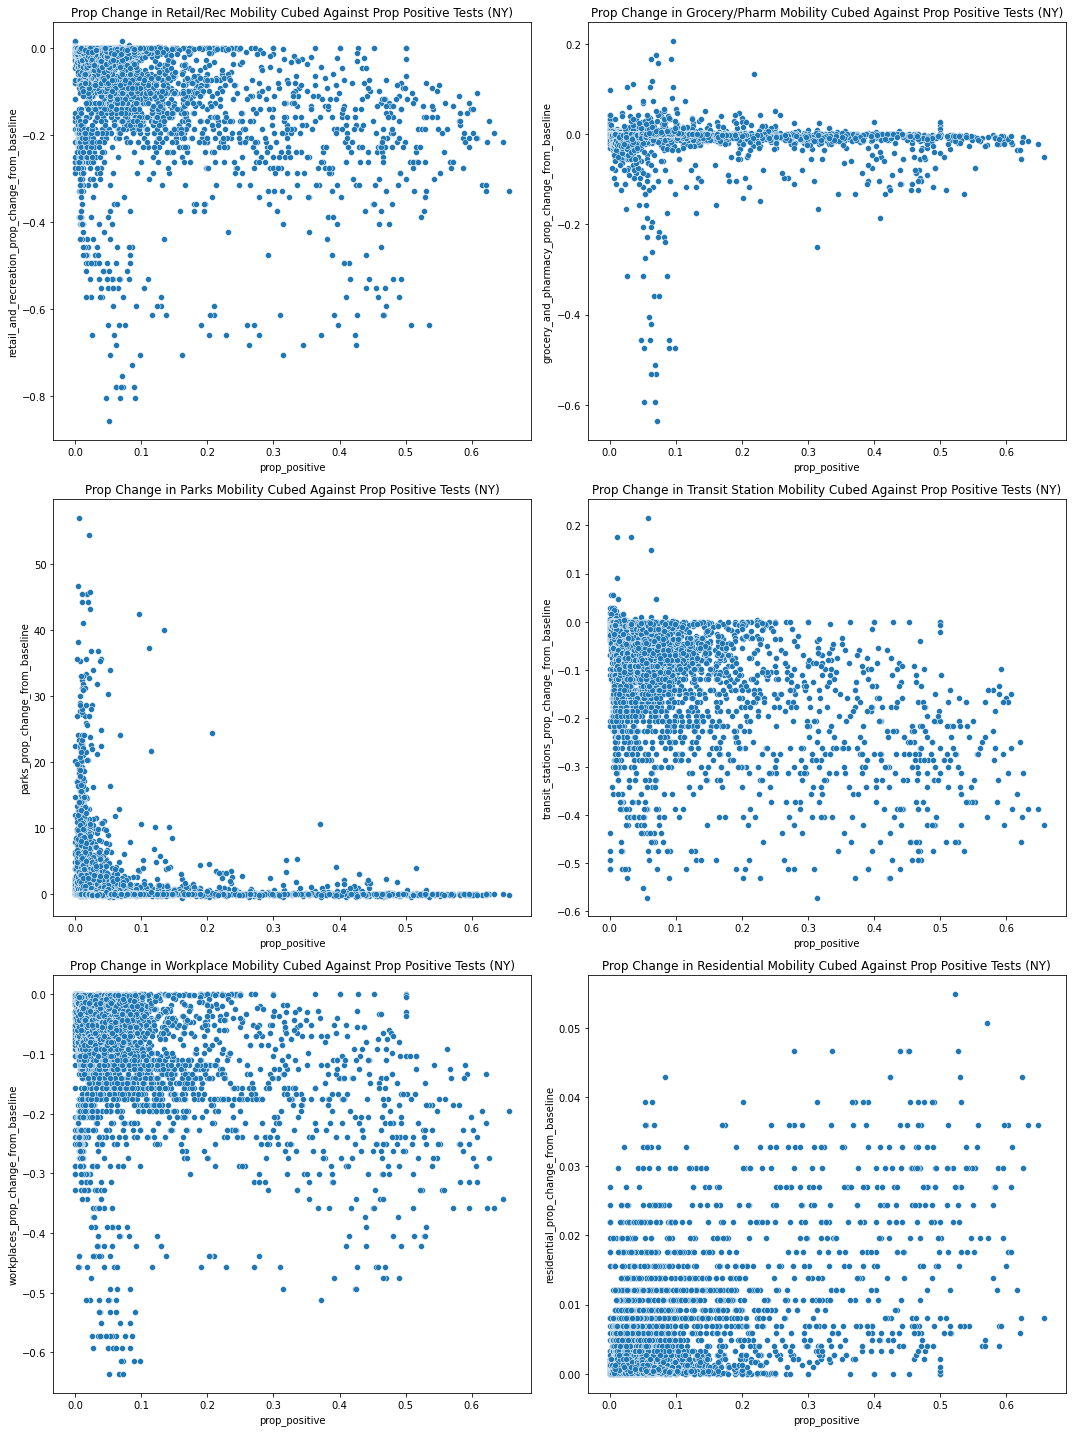

In [11]:
# NY

fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ny_data['prop_positive'], ny_data['retail_and_recreation_prop_change_from_baseline']**3, 
                ax = ax[0][0]).set_title(
'Prop Change in Retail/Rec Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['grocery_and_pharmacy_prop_change_from_baseline']**3,
               ax = ax[0][1]).set_title(
'Prop Change in Grocery/Pharm Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['parks_prop_change_from_baseline']**3, 
                ax = ax[1][0]).set_title(
'Prop Change in Parks Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['transit_stations_prop_change_from_baseline']**3, 
                ax = ax[1][1]).set_title(
'Prop Change in Transit Station Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['workplaces_prop_change_from_baseline']**3, 
                ax = ax[2][0]).set_title(
'Prop Change in Workplace Mobility Cubed Against Prop Positive Tests (NY)')

sns.scatterplot(ny_data['prop_positive'], ny_data['residential_prop_change_from_baseline']**3, 
                ax = ax[2][1]).set_title(
'Prop Change in Residential Mobility Cubed Against Prop Positive Tests (NY)')

plt.tight_layout()

## #2

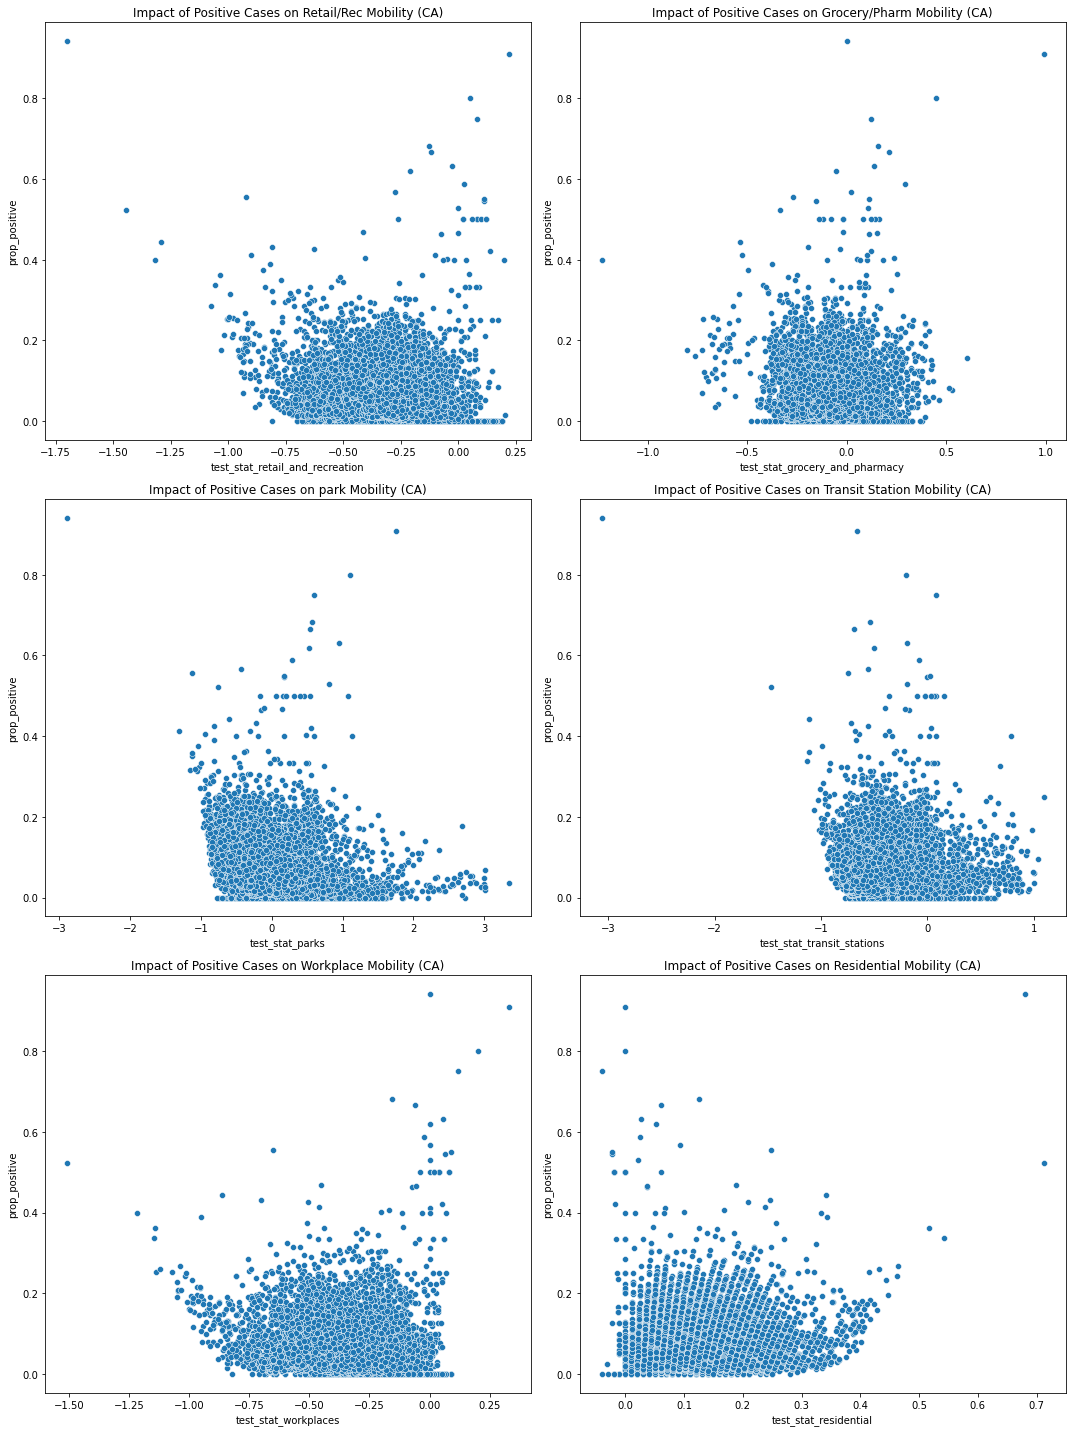

In [12]:
# Plotting the the proportion of positive COVID-19 tests against our test statistic for measusing the impact of
# these cases on different kinds of mobility. The graphs seem to indicate that a higher proportion of test cases
# has led to lower retail and recreational, and workspace mobility, higher park and residential mobility, and roughly
# no change in grocery and pharmacy and transit station mobility. This is in-line with our own assumptions that
# the pandemic led to more people staying home or going to outdoor spaces and less people going to work (WFH) and
# going to public places like transit stations or doing in-door recreational activities. Essential activities like
# grocery shopping remain less impacted.

# CA

fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ca_data['test_stat_retail_and_recreation'], ca_data['prop_positive'],
                ax = ax[0][0]).set_title(
'Impact of Positive Cases on Retail/Rec Mobility (CA)')

sns.scatterplot(ca_data['test_stat_grocery_and_pharmacy'], ca_data['prop_positive'],
               ax = ax[0][1]).set_title(
'Impact of Positive Cases on Grocery/Pharm Mobility (CA)')

sns.scatterplot(ca_data['test_stat_parks'], ca_data['prop_positive'],
                ax = ax[1][0]).set_title(
'Impact of Positive Cases on park Mobility (CA)')

sns.scatterplot(ca_data['test_stat_transit_stations'], ca_data['prop_positive'],
                ax = ax[1][1]).set_title(
'Impact of Positive Cases on Transit Station Mobility (CA)')

sns.scatterplot(ca_data['test_stat_workplaces'], ca_data['prop_positive'],
                ax = ax[2][0]).set_title(
'Impact of Positive Cases on Workplace Mobility (CA)')

sns.scatterplot(ca_data['test_stat_residential'], ca_data['prop_positive'],
                ax = ax[2][1]).set_title(
'Impact of Positive Cases on Residential Mobility (CA)')

plt.tight_layout()

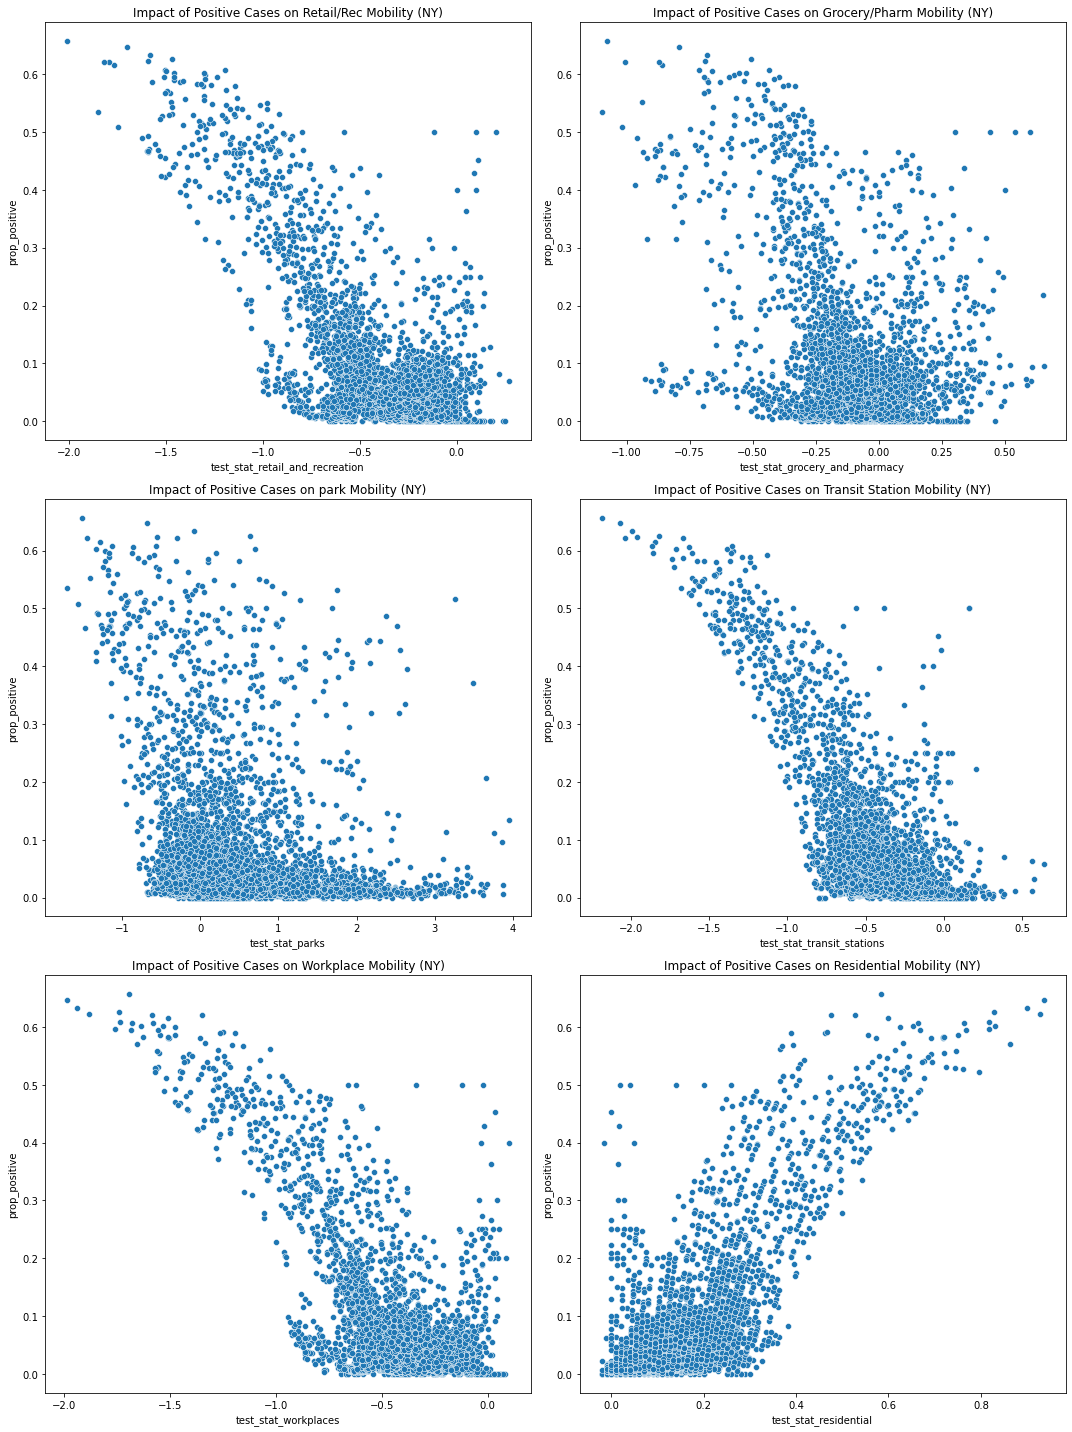

In [13]:
# NY

fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.scatterplot(ny_data['test_stat_retail_and_recreation'], ny_data['prop_positive'],
                ax = ax[0][0]).set_title(
'Impact of Positive Cases on Retail/Rec Mobility (NY)')

sns.scatterplot(ny_data['test_stat_grocery_and_pharmacy'], ny_data['prop_positive'],
               ax = ax[0][1]).set_title(
'Impact of Positive Cases on Grocery/Pharm Mobility (NY)')

sns.scatterplot(ny_data['test_stat_parks'], ny_data['prop_positive'],
                ax = ax[1][0]).set_title(
'Impact of Positive Cases on park Mobility (NY)')

sns.scatterplot(ny_data['test_stat_transit_stations'], ny_data['prop_positive'],
                ax = ax[1][1]).set_title(
'Impact of Positive Cases on Transit Station Mobility (NY)')

sns.scatterplot(ny_data['test_stat_workplaces'], ny_data['prop_positive'],
                ax = ax[2][0]).set_title(
'Impact of Positive Cases on Workplace Mobility (NY)')

sns.scatterplot(ny_data['test_stat_residential'], ny_data['prop_positive'],
                ax = ax[2][1]).set_title(
'Impact of Positive Cases on Residential Mobility (NY)')

plt.tight_layout()

## Methods

**Describe the hypotheses that you’ll be testing using your dataset (you must test at least
5 different hypotheses), and explain why it makes sense to test many hypotheses instead
of just one to answer your question.**

1) *Null Hypothesis 1:* There is no impact on the proportion of positive COVID-19 test cases in a state and the proportion change in retail and recreational mobility above baseline.

*Alternative Hypothesis 1:* There is an impact on the proportion of positive COVID-19 test cases in a state and the proportion change in retail and recreational mobility above baseline.

2) *Null Hypothesis 2:* There is no impact on the proportion of positive COVID-19 test cases in a state and the proportion change in grocery and pharmacy mobility above baseline.

*Alternative Hypothesis 2:* There is an impact on the proportion of positive COVID-19 test cases in a state and the proportion change in grocery and pharmacy mobility above baseline.

3) *Null Hypothesis 3:* There is no impact on the proportion of positive COVID-19 test cases in a state and the proportion change in park mobility above baseline.

*Alternative Hypothesis 3:* There is an impact on the proportion of positive COVID-19 test cases in a state and the proportion change in park mobility above baseline.

4) *Null Hypothesis 4:* There is no impact on the proportion of positive COVID-19 test cases in a state and the proportion change in transit station mobility above baseline.

*Alternative Hypothesis 4:* There is an impact on the proportion of positive COVID-19 test cases in a state and the proportion change in transit station mobility above baseline.

5) *Null Hypothesis 5:* There is no impact on the proportion of positive COVID-19 test cases in a state and the proportion change in workplace mobility above baseline.

*Alternative Hypothesis 5:* There is an impact on the proportion of positive COVID-19 test cases in a state and the proportion change in workplace mobility above baseline.

6) *Null Hypothesis 6:* There is no impact on the proportion of positive COVID-19 test cases in a state and the proportion change in residential mobility above baseline.

*Alternative Hypothesis 6:* There is an impact on the proportion of positive COVID-19 test cases in a state and the proportion change in residential mobility above baseline.

It makes sense to test multiple hypotheses because each type of mobiliy is impacted differently by the pandemic and to determine whether or not the impact of positive test cases was a significant one, breaking down the problem to make it more granular will give us a better understanding of how mobility is affected, if at all.

**Describe how you’ll be testing each hypothesis.**

1) We created a separate dataframe for each type of mobility and each state with one column containing the test statistic for impact of positive COVID-19 tests on that kind of mobility.

2) We created a function that takes a bootstrap sample, computes replicates, and returns an array of replicates.

3) We used the function to draw 20,000 random bootstrap samples from the data and compute a mean for the test statistic for impact of positive COVID-19 tests on each kind of mobility.

4) We plotted the probability density function of these means and constructed a 95% confidence interval.

5) If the confidence interval contained 0, we fail to reject the null hypothesis at a 5% significance level. If it does not contain 0, we reject the null at a 5% significance level.

**Describe at least two different ways you’ll correct for multiple hypothesis tests, and explain
the error rates being controlled**

1) Bonferroni Correction: This is used to correct inflated familywise type I error rate (higher chance of false positives i.e. incorrectly rejecting the null hypothesis) by adjusting for multiplicity. 

When looking at multiple hypotheses on the same dependent variable (proportion of positive COVID-19 tests), we increase the likelihood of coming about a significant result by pure chance. To claim that some of the multiple comparisons we are looking at are statistically significant at the 5% level, we can divide the significance level by the number of hypotheses (0.05/6 = 0.00833) and find teh 99.17% confidence interval instead of 95%.

2) Benjamini-Hochberg: (Caitlin)

In [14]:
# create a separate dataframe for each type of mobility and each state with one column containing 
# the test statistic for impact of positive COVID-19 tests on that kind of mobility

ca_ret = ca_data['test_stat_retail_and_recreation']
ca_groc = ca_data['test_stat_grocery_and_pharmacy']
ca_park = ca_data['test_stat_parks']
ca_transit = ca_data['test_stat_transit_stations']
ca_work = ca_data['test_stat_workplaces']
ca_res = ca_data['test_stat_residential']

ny_ret = ny_data['test_stat_retail_and_recreation']
ny_groc = ny_data['test_stat_grocery_and_pharmacy']
ny_park = ny_data['test_stat_parks']
ny_transit = ny_data['test_stat_transit_stations']
ny_work = ny_data['test_stat_workplaces']
ny_res = ny_data['test_stat_residential']

In [15]:
def draw_bs_replicates(data,func,size):
    
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    
    # Create an empty array to store replicates
    
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    
    for i in range(size):
        
        # Create a bootstrap sample
        
        bs_sample = np.random.choice(data, size = data.shape[0])
        
        # Get bootstrap replicate and append to bs_replicates
        
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [16]:
# use the function to draw 20,000 random bootstrap samples from the data and compute a mean for the 
# test statistic for impact of positive COVID-19 tests on each kind of mobility.

bs_replicates_ca_ret = draw_bs_replicates(ca_ret, np.mean, 20000)
bs_replicates_ca_groc = draw_bs_replicates(ca_groc, np.mean, 20000)
bs_replicates_ca_park = draw_bs_replicates(ca_park, np.mean, 20000)
bs_replicates_ca_transit = draw_bs_replicates(ca_transit, np.mean, 20000)
bs_replicates_ca_work = draw_bs_replicates(ca_work, np.mean, 20000)
bs_replicates_ca_res = draw_bs_replicates(ca_res, np.mean, 20000)

bs_replicates_ny_ret = draw_bs_replicates(ny_ret, np.mean, 20000)
bs_replicates_ny_groc = draw_bs_replicates(ny_groc, np.mean, 20000)
bs_replicates_ny_park = draw_bs_replicates(ny_park, np.mean, 20000)
bs_replicates_ny_transit = draw_bs_replicates(ny_transit, np.mean, 20000)
bs_replicates_ny_work = draw_bs_replicates(ny_work, np.mean, 20000)
bs_replicates_ny_res = draw_bs_replicates(ny_res, np.mean, 20000)

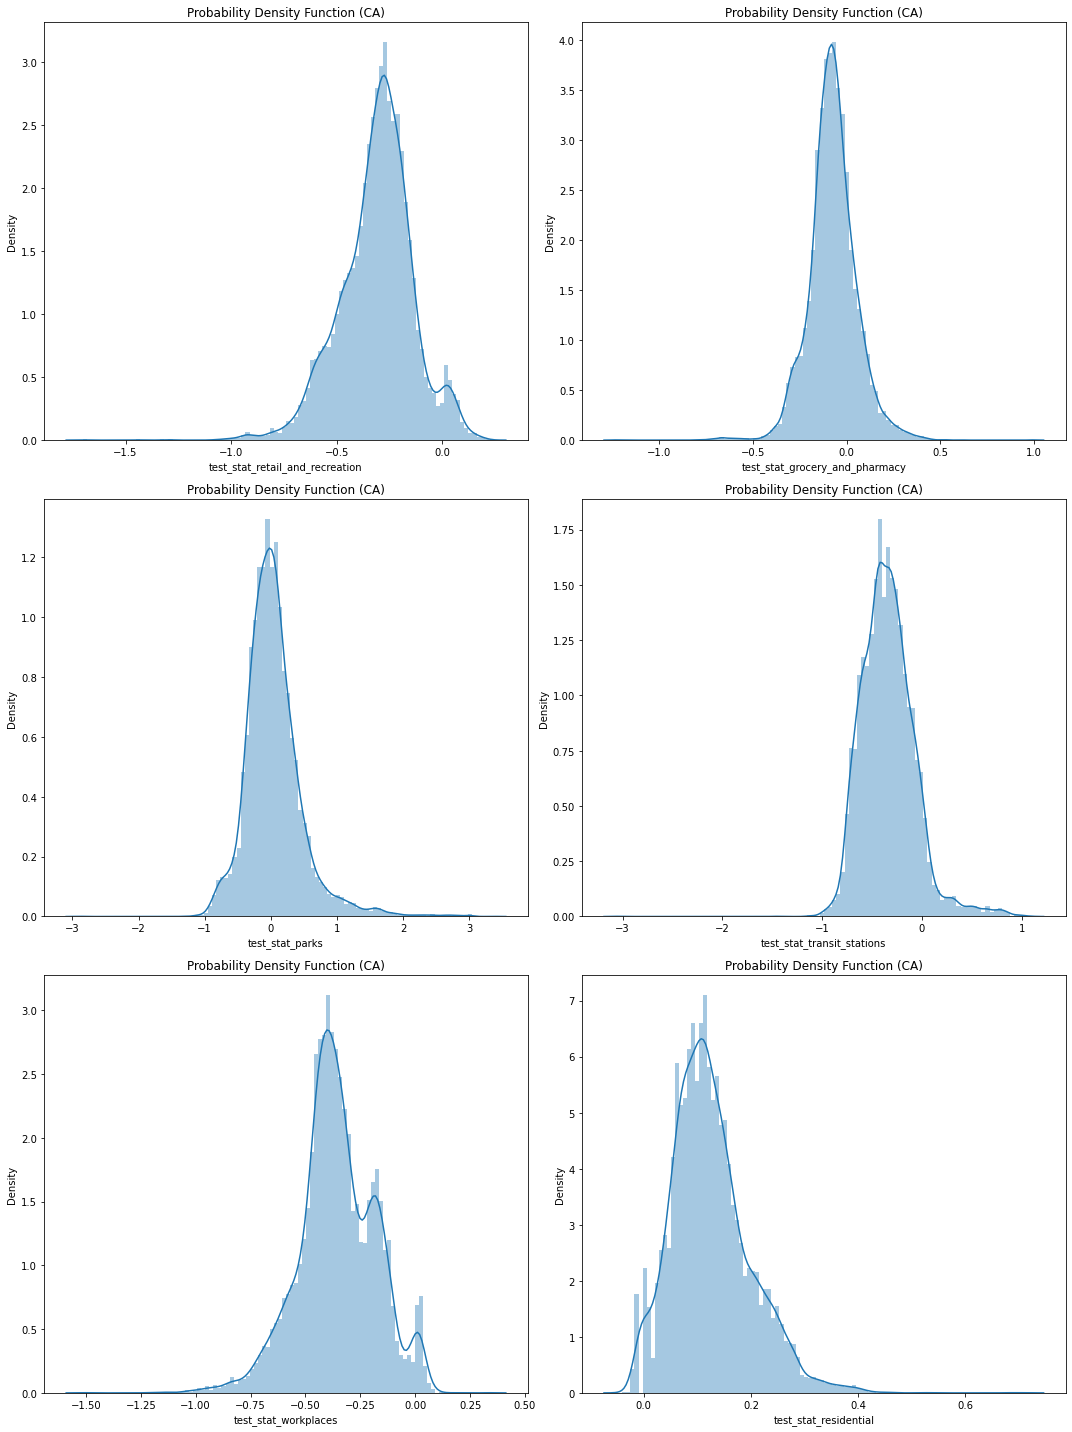

In [17]:
# plot the probability density function with kde of the mean of each of the 20,000 samples

# CA

fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.distplot(ca_ret, bins = 100, ax = ax[0][0]).set_title("Probability Density Function (CA)")
sns.distplot(ca_groc, bins = 100, ax = ax[0][1]).set_title("Probability Density Function (CA)")
sns.distplot(ca_park, bins = 100, ax = ax[1][0]).set_title("Probability Density Function (CA)")
sns.distplot(ca_transit, bins = 100, ax = ax[1][1]).set_title("Probability Density Function (CA)")
sns.distplot(ca_work, bins = 100, ax = ax[2][0]).set_title("Probability Density Function (CA)")
sns.distplot(ca_res, bins = 100, ax = ax[2][1]).set_title("Probability Density Function (CA)")

plt.tight_layout()

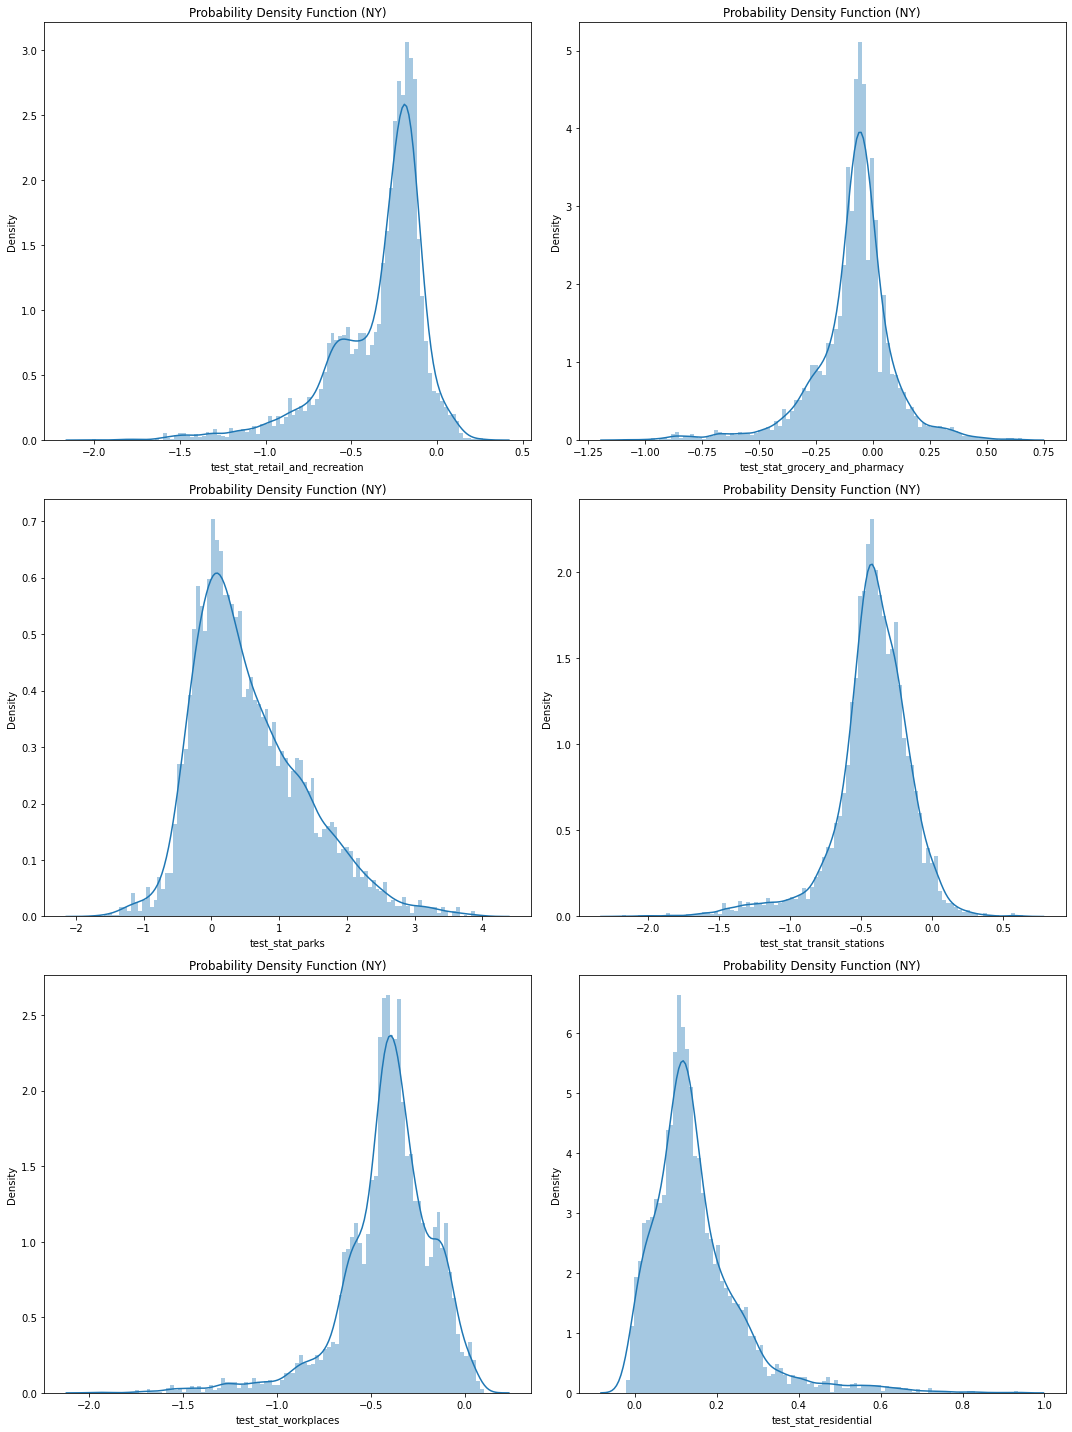

In [18]:
# NY

fig, ax = plt.subplots(3, 2, figsize=(15, 20))

sns.distplot(ny_ret, bins = 100, ax = ax[0][0]).set_title("Probability Density Function (NY)")
sns.distplot(ny_groc, bins = 100, ax = ax[0][1]).set_title("Probability Density Function (NY)")
sns.distplot(ny_park, bins = 100, ax = ax[1][0]).set_title("Probability Density Function (NY)")
sns.distplot(ny_transit, bins = 100, ax = ax[1][1]).set_title("Probability Density Function (NY)")
sns.distplot(ny_work, bins = 100, ax = ax[2][0]).set_title("Probability Density Function (NY)")
sns.distplot(ny_res, bins = 100, ax = ax[2][1]).set_title("Probability Density Function (NY)")

plt.tight_layout()

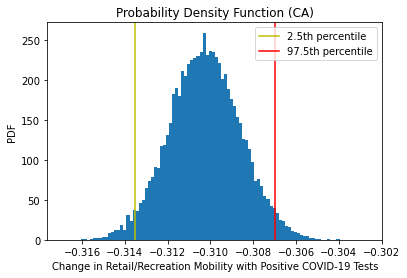

In [19]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ca_ret,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ca_ret,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ca_ret,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Retail/Recreation Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")

plt.title("Probability Density Function (CA)")
plt.legend()

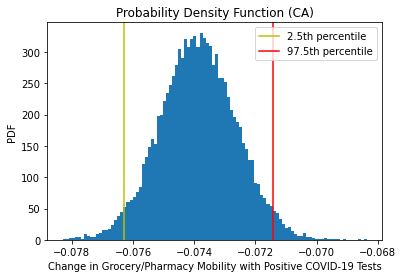

In [20]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ca_groc,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ca_groc,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ca_groc,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Grocery/Pharmacy Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (CA)")
plt.legend()

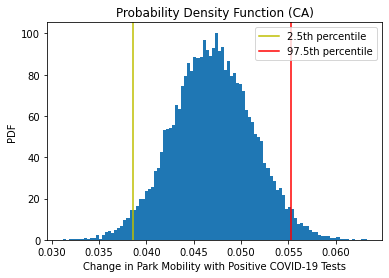

In [21]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ca_park,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ca_park,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ca_park,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Park Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (CA)")
plt.legend()

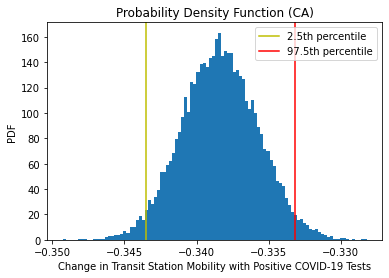

In [22]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ca_transit,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ca_transit,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ca_transit,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Transit Station Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (CA)")
plt.legend()

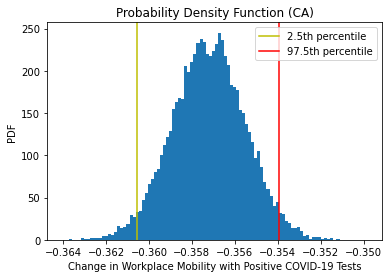

In [23]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ca_work,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ca_work,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ca_work,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Workplace Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (CA)")
plt.legend()

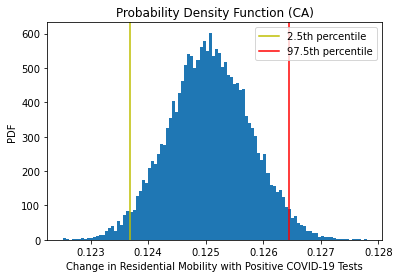

In [24]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ca_res,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ca_res,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ca_res,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Residential Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (CA)")
plt.legend()

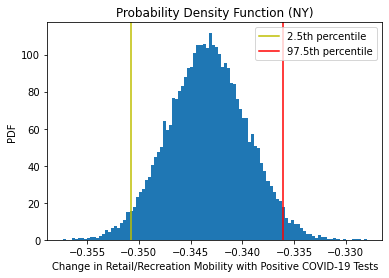

In [25]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ny_ret,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ny_ret,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ny_ret,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Retail/Recreation Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (NY)")
plt.legend()

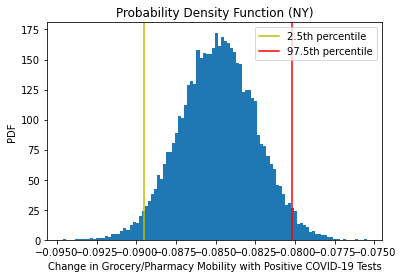

In [26]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ny_groc,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ny_groc,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ny_groc,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Grocery/Pharmacy Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (NY)")
plt.legend()

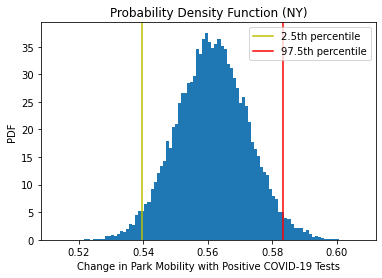

In [27]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ny_park,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ny_park,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ny_park,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Park Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (NY)")
plt.legend()

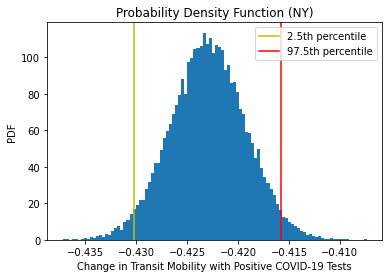

In [28]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ny_transit,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ny_transit,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ny_transit,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Transit Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (NY)")
plt.legend()

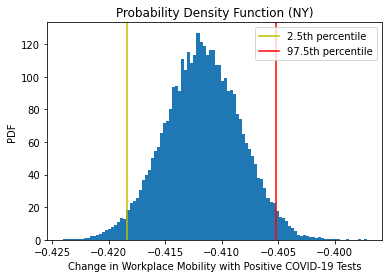

In [29]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ny_work,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ny_work,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ny_work,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Workplace Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (NY)")
plt.legend()

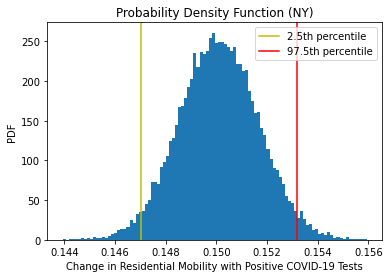

In [30]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_ny_res,bins=100,density=True)

# Showing the related 95% percentiles
plt.axvline(x=np.percentile(bs_replicates_ny_res,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_ny_res,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Change in Residential Mobility with Positive COVID-19 Tests")
plt.ylabel("PDF")
plt.title("Probability Density Function (NY)")
plt.legend()

In [31]:
# code resource: https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d

In [32]:
print("The 95% confidence interval for retail/recreational mobility in CA is: ",np.percentile(bs_replicates_ca_ret,[2.5,97.5]))
print("The 95% confidence interval for grocery/pharmacy mobility in CA is: ",np.percentile(bs_replicates_ca_groc,[2.5,97.5]))
print("The 95% confidence interval for park mobility in CA is: ",np.percentile(bs_replicates_ca_park,[2.5,97.5]))
print("The 95% confidence interval for transit station mobility in CA is: ",np.percentile(bs_replicates_ca_transit,[2.5,97.5]))
print("The 95% confidence interval for workplace mobility in CA is: ",np.percentile(bs_replicates_ca_work,[2.5,97.5]))
print("The 95% confidence interval for residential mobility in CA is: ",np.percentile(bs_replicates_ca_res,[2.5,97.5]))

The 95% confidence interval for retail/recreational mobility in CA is:  [-0.31353978 -0.30697171]
The 95% confidence interval for grocery/pharmacy mobility in CA is:  [-0.07630784 -0.07141739]
The 95% confidence interval for park mobility in CA is:  [0.03864227 0.05528061]
The 95% confidence interval for transit station mobility in CA is:  [-0.34346919 -0.33319765]
The 95% confidence interval for workplace mobility in CA is:  [-0.3605587  -0.35392291]
The 95% confidence interval for residential mobility in CA is:  [0.12368415 0.12644772]


In [33]:
print("The 95% confidence interval for retail/recreational mobility in NY is: ",np.percentile(bs_replicates_ny_ret,[2.5,97.5]))
print("The 95% confidence interval for grocery/pharmacy mobility in NY is: ",np.percentile(bs_replicates_ny_groc,[2.5,97.5]))
print("The 95% confidence interval for park mobility in NY is: ",np.percentile(bs_replicates_ny_park,[2.5,97.5]))
print("The 95% confidence interval for transit station mobility in NY is: ",np.percentile(bs_replicates_ny_transit,[2.5,97.5]))
print("The 95% confidence interval for workplace mobility in NY is: ",np.percentile(bs_replicates_ny_work,[2.5,97.5]))
print("The 95% confidence interval for residential mobility in NY is: ",np.percentile(bs_replicates_ny_res,[2.5,97.5]))

The 95% confidence interval for retail/recreational mobility in NY is:  [-0.35079762 -0.33603693]
The 95% confidence interval for grocery/pharmacy mobility in NY is:  [-0.08952317 -0.0801953 ]
The 95% confidence interval for park mobility in NY is:  [0.53967185 0.58328018]
The 95% confidence interval for transit station mobility in NY is:  [-0.43026117 -0.41576138]
The 95% confidence interval for workplace mobility in NY is:  [-0.41834011 -0.40517742]
The 95% confidence interval for residential mobility in NY is:  [0.14704088 0.15317887]


In [34]:
# bonferroni correction lower and upper bounds

lower = 5/12
upper = 100 - (5/12)

In [35]:
print("The 99.17% confidence interval for retail/recreational mobility in CA is: ",np.percentile(bs_replicates_ca_ret,[lower,upper]))
print("The 99.17% confidence interval for grocery/pharmacy mobility in CA is: ",np.percentile(bs_replicates_ca_groc,[lower,upper]))
print("The 99.17% confidence interval for park mobility in CA is: ",np.percentile(bs_replicates_ca_park,[lower,upper]))
print("The 99.17% confidence interval for transit station mobility in CA is: ",np.percentile(bs_replicates_ca_transit,[lower,upper]))
print("The 99.17% confidence interval for workplace mobility in CA is: ",np.percentile(bs_replicates_ca_work,[lower,upper]))
print("The 99.17% confidence interval for residential mobility in CA is: ",np.percentile(bs_replicates_ca_res,[lower,upper]))

The 99.17% confidence interval for retail/recreational mobility in CA is:  [-0.31462507 -0.30587905]
The 99.17% confidence interval for grocery/pharmacy mobility in CA is:  [-0.07720102 -0.07051846]
The 99.17% confidence interval for park mobility in CA is:  [0.03582814 0.05812321]
The 99.17% confidence interval for transit station mobility in CA is:  [-0.34522611 -0.33138646]
The 99.17% confidence interval for workplace mobility in CA is:  [-0.36177214 -0.35281138]
The 99.17% confidence interval for residential mobility in CA is:  [0.12325448 0.12691985]


In [36]:
print("The 99.17% confidence interval for retail/recreational mobility in CA is: ",np.percentile(bs_replicates_ny_ret,[lower,upper]))
print("The 99.17% confidence interval for grocery/pharmacy mobility in CA is: ",np.percentile(bs_replicates_ny_groc,[lower,upper]))
print("The 99.17% confidence interval for park mobility in CA is: ",np.percentile(bs_replicates_ny_park,[lower,upper]))
print("The 99.17% confidence interval for transit station mobility in CA is: ",np.percentile(bs_replicates_ny_transit,[lower,upper]))
print("The 99.17% confidence interval for workplace mobility in CA is: ",np.percentile(bs_replicates_ny_work,[lower,upper]))
print("The 99.17% confidence interval for residential mobility in CA is: ",np.percentile(bs_replicates_ny_res,[lower,upper]))

The 99.17% confidence interval for retail/recreational mobility in CA is:  [-0.35327055 -0.33352687]
The 99.17% confidence interval for grocery/pharmacy mobility in CA is:  [-0.09120665 -0.07857791]
The 99.17% confidence interval for park mobility in CA is:  [0.53226162 0.59093982]
The 99.17% confidence interval for transit station mobility in CA is:  [-0.43278979 -0.4130812 ]
The 99.17% confidence interval for workplace mobility in CA is:  [-0.42063123 -0.40295809]
The 99.17% confidence interval for residential mobility in CA is:  [0.14598213 0.15428952]


## Results

**Summarize and interpret the results from the hypothesis tests themselves.**

1) *Hypothesis 1:* The 95% CI does not contain 0 so we reject the null at the 5% significance level. This implies that an increase in the proportion of positive tests actually decreased retail/recreational mobility.

2) *Hypothesis 2:* The 95% CI does not contain 0 so we reject the null at the 5% significance level. This implies that an increase in the proportion of positive tests decreased grocery/pharmacy mobility, but very slightly.

3) *Hypothesis 3:* The 95% CI does not contain 0 so we reject the null at the 5% significance level. This implies that an increase in the proportion of positive tests actually increased park mobility.

4) *Hypothesis 4:* The 95% CI does not contain 0 so we reject the null at the 5% significance level. This implies that an increase in the proportion of positive tests actually decreased transit station mobility.

5) *Hypothesis 5:* The 95% CI does not contain 0 so we reject the null at the 5% significance level. This implies that an increase in the proportion of positive tests actually decreased workplace mobility.

6) *Hypothesis 6:* The 95% CI does not contain 0 so we reject the null at the 5% significance level. This implies that an increase in the proportion of positive tests actually increased residential mobility.

**For the two correction methods you chose, clearly explain what kind of error rate is being
controlled by each one.**

1) Bonferroni Correction: The FWER is being controlled, which is the probability of making one or more false discoveries, or type I errors when performing multiple hypothesis testing. In this scenario, it means that we reduce the chances of incorrectly rejecting the null, which we have rejected for all 6 hypotheses, that mobility has not been impacted by the proportion of posiive COVID-19 tests.

2) Benjamini-Hochberg: (Caitlin)

## Discussion (Caitlin)

**After applying your correction procedures, which discoveries remained significant? If none
did, explain why.**

1) Bonferroni Correction: We still reject all the nulls at the 5% level.

**What decisions can or should be made from the individual tests? What about from the
results in aggregate?**



**Discuss any limitations in your analysis, and if relevant, how you avoided p-hacking.**



**What additional tests would you conduct if you had more data?**